In this notebook we will use a traditional machine learning approach to perform a classification task. The goal is to create a model that can accurately predict the class of an unseen image (an image the model hasn't been trained on). The dataset used is the malaria cell images dataset from Kaggle. The dataset contains 27558 images of cells, half of which are parasitised, and half of which are uninfected. This notebook is intended to run using Google Colab. 

To use a traditional approach we first need to extract features from the images that our model will be able to understand. Convolutional neural networks do this automatically, but traditional methods don't. 

First we need to import the modules that we're going to use in this notebook:

In [1]:
# Importing necessary modules
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

Next, we need to download the dataset from Kaggle. For this you will need a Kaggle account. You will need to replace USER_NAME_HERE with your username, and KEY_HERE with your Kaggle API key. 

In [2]:
# Downloading the dataset

os.environ['KAGGLE_USERNAME'] = 'samhedley'
os.environ['KAGGLE_KEY'] = 'KGAT_b7cd8b87cb2a0346ef10f-b182f099721'
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --unzip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
100% 675M/675M [00:11<00:00, 88.5MB/s]
100% 675M/675M [00:11<00:00, 60.4MB/s]


Next, we need to define the directory to the cell images (our data).

Then we can begin to plot some of the images and see what they look like. To do this, I defined paths to the parasitised and uninfected directories and created lists containing the first few from each class (parasitised and uninfected), before combining the lists. Then we loop through the list plotting each image and adding the corresponding label. 

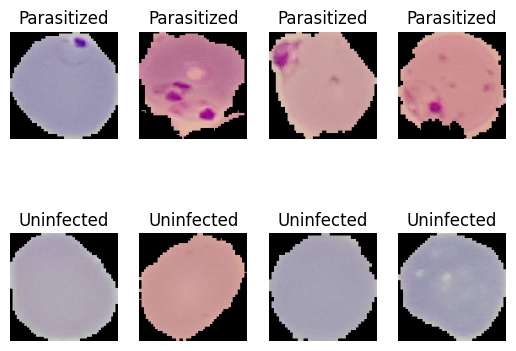

In [3]:
# Visualizing sample images from the dataset

# Setting up directories
data_dir = "./cell_images" # Directory for the dataset

# Directories for the two classes
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

# Sample images to display
parasitized_imgs = os.listdir(parasitized_dir)[:4]
uninfected_imgs = os.listdir(uninfected_dir)[:4]

imgs = parasitized_imgs + uninfected_imgs

# Plotting the images
for i in range(len(imgs)):
    if i < 4: # Selecting only parasitized images for the first half
        img_path = os.path.join(parasitized_dir, imgs[i])
        label = 'Parasitized'
    else: # Selecting uninfected images for the second half
        img_path = os.path.join(uninfected_dir, imgs[i])
        label = 'Uninfected'
    # Load and display the images
    img = image.load_img(img_path, target_size=(128, 128))
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

To use a traditional approach we first need to extract features from the images that our model will be able to process. Convolutional neural networks do this automatically, but traditional models don't.

A commonly used and effective method of feature extraction is Histogram of Oriented Gradients (HOG). The idea behind HOG is that the local appearance and shape of objects within an image can be described by the distribution of pixel intensity gradients. HOG works by splitting the image into cells, and for each cell counting how often gradients of pixel intensity point in certain directions. It creates a histogram of these gradients, and each histogram is combined to form the feature descriptor. 

Below we create a function that performs HOG on our dataset. The function will call the directory path. 

First, we define img_size as 64 pixels for later. 
Next, we create empty lists to store HOG features and the image labels (classes). 
Then we loop over every image in both the parisitised and uninfected directories, and try to:
1. Get the full path to the image
2. Read-in the image in grayscale using cv2. We convert the images to grayscale as there's not much benefit to keeping colour information, and it saves computation time and memory by having 1 colour channel instead of 2.
3. Resize the image to img_size x img_size, which we defined as 64 pixels earlier.
4. Rescale the pixel values to [0, 1] by dividing them by 255. This helps with data processing.
5. Next, we actually do HOG, using 'hog' from skimage.feature. We do this with 9 orientations, 8x8 pixels per cell and 2x2 cells per block. 
6. The HOG vector is appended to the features list we made earlier.
7. We append the class to the labels list. The class is 0 if parasitised, and 1 if uninfected. 

If there are any files in the directory that are corrupted or aren't images (there are two that aren't), except: pass will pass that file in the loop and move to the next one.
The function then returns the features and labels lists.

In [4]:
# Histogram of Oriented Gradients (HOG) Feature Extraction

img_size = 64 # Resizing images to 64x64 for HOG

# Function to extract HOG features
def HOG(folder_path):
    features = [] # List to store HOG features
    labels = [] # List to store labels

    for label in ['Parasitized', 'Uninfected']: # Looping through both classes
        class_dir = os.path.join(folder_path, label) # Directory for the current class
        for img_name in os.listdir(class_dir): # Looping through images in the class directory
            try: # Some files might be corrupted or unreadable, so we use try-except to pass those
                img_path = os.path.join(class_dir, img_name) # Full path to the image
                
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Read image in grayscale
                img = cv2.resize(img, (img_size, img_size)) # Resize image
                img = img / 255.0 # Normalize pixel values to [0, 1]

                # Extract HOG features
                hog_vector = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
                
                features.append(hog_vector) # Append HOG features to the list
                labels.append(0 if label == 'Parasitized' else 1) # Append label (0 for Parasitized, 1 for Uninfected)

            except:
                pass # Skip unreadable images / files that are not images
            
    return features, labels # Return features and labels

Here we simply use the function on our dataset (directory 'data_dir'). X = features, y = labels.

In [5]:
# Extracting HOG features and labels from the dataset
X, y = HOG(data_dir) # X contains HOG features, y contains labels

Now we need to split our features and labels into training and test sets. The training set is used to train the model, and the test set is used to test the model. 
To do this we use train_test_split from sklearn.model_selection. We choose a test size of 25%, and use a random seed of 42. We also use stratify to ensure that the training and test splits have an equal proportion of each class as the original dataset does (so 50/50). In this case because the original dataset has no class imbalance it doesn't matter so much, but for datasets with minority classes it reduces class bias.

We then use StandardScaler from sklearn.preprocessing to standardise the features (0 mean with unit variance). Many models perform poorly if the features aren't standardised, including support vector machines like the one we will use (linear support vector classifier, LinearSVC).

In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now we initialise, fit (train), and test the model. We use LinearSVC, which is a linear Support Vector Machine (SVM) method. Linear SVMs work very well with HOG and are commonly used together for computer vision and object recognition tasks. Using LinearSVC instead of SVC with a linear kernel reduced computation time greatly, which is why LinearSVC is used instead.

First we initise the model. Then we fit the model to the training data (X_train and y_train). 

Then we use the trained model to predict the classes of our test set (X_test) using .predict, and we print the accuracy using accuracy_score, and classification report, which compare y_test (the actual class labels) with y_pred (the predicted class labels). 

In [7]:
# Training a Linear Support Vector Machine (SVM) Classifier

svm = LinearSVC(C=0.001, max_iter=1000) # Initializing the Linear SVM classifier

svm.fit(X_train, y_train) # Training the SVM classifier

y_pred = svm.predict(X_test) # Predicting labels for the test set

print("Accuracy:", accuracy_score(y_test, y_pred)) # Printing accuracy of the model
print(classification_report(y_test, y_pred)) # Printing classification report

Accuracy: 0.8457184325108853
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3445
           1       0.83      0.87      0.85      3445

    accuracy                           0.85      6890
   macro avg       0.85      0.85      0.85      6890
weighted avg       0.85      0.85      0.85      6890



You should get an accuracy around 84%, which isn't too bad for an image classification task with a traditional model. But a convolutional neural network works much better, as shown in notebook Q2.ipynb.